In [11]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG

import tensorflow
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn.metrics import (classification_report, multilabel_confusion_matrix, 
                             accuracy_score, recall_score, precision_score, 
                             f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix)

## Model analysis

In this notebook, I will explore the performance of the model, which was trained to classify single dog breeds. I will explore how well the model classifies the 120 breeds that it trained with, and will also conduct a misclassification analysis.

Lastly, for the fun part, we will see how well the model can classify mixed dogs. 

In [2]:
model = load_model('./model_data_softmax/')

2022-06-10 09:35:44.910742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Prepare the images for predictions

In [3]:
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
#num_images= 50
image_arr_size= img_width * img_height * channels

In [4]:
test_data_path = './Testing_images/'

In [5]:
test_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle=False
)

Found 3633 images belonging to 120 classes.


In [6]:
class_indeces = test_generator.class_indices
label_names = list(test_generator.class_indices.keys())
y_true = test_generator.classes

In [7]:
preds = model.predict(test_generator)
single_breed_preds = np.argmax(preds, axis=1)

### Model high-level performance report

In [8]:
classification_report = classification_report(y_true, single_breed_preds, target_names=label_names)
print(classification_report)

                                precision    recall  f1-score   support

                 Affenpinscher       0.76      1.00      0.87        13
                        Afghan       0.98      0.98      0.98        50
              African Wild Dog       0.98      1.00      0.99        50
                      Airedale       0.92      0.92      0.92        50
American Staffordshire Terrier       0.81      0.92      0.86        50
                   Appenzeller       1.00      0.33      0.50        12
            Australian Terrier       0.50      1.00      0.67        12
                       Basenji       0.96      1.00      0.98        50
                        Basset       0.98      0.96      0.97        50
                        Beagle       0.94      0.94      0.94        50
            Bedlington Terrier       1.00      1.00      1.00        13
          Bernese Mountain Dog       1.00      0.96      0.98        50
       Black-and-Tan Coonhound       0.71      0.91      0.80  

## Analysis of most misclassified breeds
 We will review the breeds with low recall scores (below < 0.50) and breeds with low precision scores (below <0.50) to see if we can gain any insight as to the model's mistakes

#### Pull the breeds that were most misclassified

In [12]:
report_dict = classification_report(y_true, single_breed_preds, target_names=label_names, output_dict=True)

In [13]:
def low_recall_precision_labels(report_dict, labels_names):
    low_recall = []
    low_precision = []
    for key in label_names:
        if report_dict[key]['recall'] < .50:
            low_recall.append(key)
        if report_dict[key]['precision'] < .50:
            low_precision.append(key)
            
    return low_recall, low_precision

In [14]:
low_recall, low_precision = low_recall_precision_labels(report_dict, label_names)
print('Low_recall:',low_recall)
print('Low_precision', low_precision)

Low_recall: ['Appenzeller', 'Brittany Spaniel', 'Cocker Spaniel', 'Eskimo Dog', 'Lakeland Terrier', 'Lhasa', 'Pinscher', 'Silky Terrier', 'Toy Poodle']
Low_precision ['Eskimo Dog', 'Giant Schnauzer', 'Kelpie', 'Miniature Poodle', 'Scottish Deerhound', 'Silky Terrier', 'Tibetan Terrier']


### Review of breeds with low recall scores

In [177]:
#### Create a dict mapping label index to breed
ind_to_label = {}
for k, i in class_indeces.items():
    ind_to_label[i] = k.title()

In [16]:
true_pred = pd.DataFrame({'y_true': y_true, 'y_pred': single_breed_preds})

In [34]:
### Structure of function below

# class_indeces['Brittany Spaniel']

# true_pred[true_pred['y_true']==class_indeces['Brittany Spaniel']]

# brittany_spaniel = true_pred[true_pred['y_true']==class_indeces['Brittany Spaniel']]
# mislabel_ind = brittany_spaniel[brittany_spaniel['y_pred']!=class_indeces['Brittany Spaniel']]
# most_mislabed = mislabel_ind['y_pred'].mode()[0]
# most_mislabed_breed = ind_to_label[most_mislabed]
# most_mislabed_breed

In [32]:
def recall_mislabeling(df, breed_list, index_dict):
    '''
    Function that returns dictionary where the keys are breeds with low recall scores
    and values are the breeds that they are mislabeled as the most.  
    
    '''
    mislabel_dict = {}
    for breed in breed_list:
        df_subset = df[df['y_true']==class_indeces[breed]]
        mislabel_ind = df_subset[df_subset['y_pred']!=class_indeces[breed]]
        most_mislabed = mislabel_ind['y_pred'].mode()[0]
        most_mislabed_breed = ind_to_label[most_mislabed]
        mislabel_dict[breed] = most_mislabed_breed
    
    return mislabel_dict

In [142]:
low_recall_dict = recall_mislabeling(true_pred, low_recall, ind_to_label)
low_recall_dict

{'Appenzeller': 'Entlebucher',
 'Brittany Spaniel': 'Welsh Springer Spaniel',
 'Cocker Spaniel': 'Irish Water Spaniel',
 'Eskimo Dog': 'Samoyed',
 'Lakeland Terrier': 'Airedale',
 'Lhasa': 'Shih-Tzu',
 'Pinscher': 'Doberman',
 'Silky Terrier': 'Australian Terrier',
 'Toy Poodle': 'Miniature Poodle'}

#### To analyze the breeds that have been most mislabeled, let's looks at images of those breeds and the breeds that they were most mistaken for:

I suspect that the model was confusing breeds that look very much like each other, let's see if that's true.

In [ ]:
# img = load_img('./Images/Appenzeller/n02107908_80.jpg')
# plt.title('Appenzeller')
# plt.axis('off')
# plt.imshow(img)

# plt.show()

In [304]:
# img1 = load_img('./Testing_images/Appenzeller/001.jpg')
# img2 = load_img('./Testing_images/Entlebucher/001.jpg')
# images = [img, img2]

In [305]:
# f, axarr = plt.subplots(1,2, figsize=(12,12))
# axarr[0].imshow(images[0])
# axarr[0].set_title('Appenzeller')
# axarr[0].axis('off')

# axarr[1].imshow(images[1])
# axarr[1].set_title('Entlebucher')
# axarr[1].axis('off');

In [317]:
mislabeled_imgs = []

for key, value in low_recall_dict.items():
    img1 = load_img('./Testing_images/'+ key + '/001.jpg')
    img2 = load_img('./Testing_images/'+ value + '/001.jpg')
    mislabeled_imgs.append([img1, img2])

In [301]:
def print_pair(image_list, title1, title2):
    f, axarr = plt.subplots(1,2, figsize=(12,12))
    axarr[0].imshow(image_list[0])
    axarr[0].set_title(title1)
    axarr[0].axis('off')

    axarr[1].imshow(image_list[1])
    axarr[1].set_title(title2)
    axarr[1].axis('off');

##### Let's explore Appenzeller which was widely misclassified as an Entlebucher

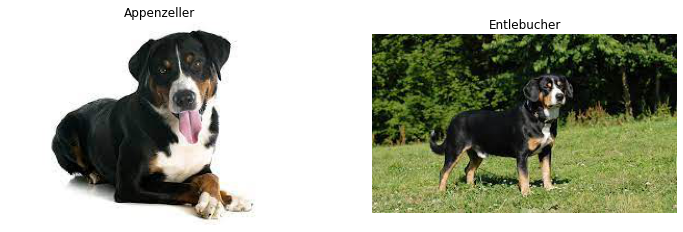

In [302]:
print_pair(mislabeled_imgs[0], 'Appenzeller', 'Entlebucher')

Both dogs have short hair and similar color pattern. In fact, both are part of the **SAME BREED GROUP** the Switzerland mountain dog, which includes the Greater Swiss Mountain Dog, the Bernese Mountain Dog,  the Entlebucher, and the Appenzeller. With the Bernese Mountain dog having the longest hair, it was distinguished enough that it enjoyed high precision and recall scores. We did not test the Swiss Mountain Dog. But the model had a hard time distinguishing the two dogs above, since there are overlaps in their size and weight, with the Entlebucher being only slightly smaller on average. Since I used data from the standford model study, I maintained the same classes as they did, but I may reconsider in the future how to treat dogs that belong to the same breed group and are very similar in appearance. 

##### Let's explore the Brittany Spaniel which was confused for the Welsh Springer Spaniel

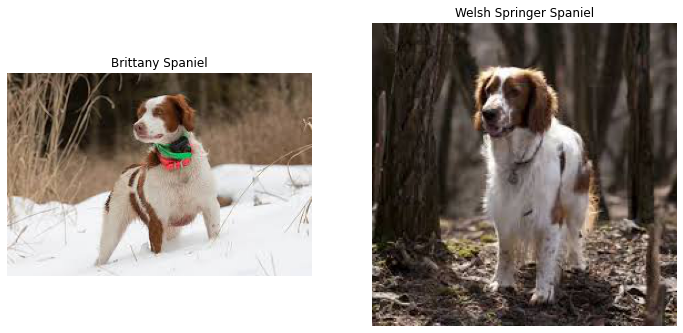

In [310]:
print_pair(mislabeled_imgs[1], 'Brittany Spaniel', 'Welsh Springer Spaniel')

These two breeds are so incredibly similar, with a mostly white coat but a very similar reddish part around the face and body. When I was reviewing images for both classes, I could hardly tell the difference, other than the Brittany Spaniel has shorter ears (on average) than the Welsh Spaniel. Another troubling part was that the Stanford data had mixed these two breeds, and so the folder for each class has incorrectly added pictures of one another. 

##### Let's see the Cocker Spaniel which was most mislabeled as an Irish Water Spaniel

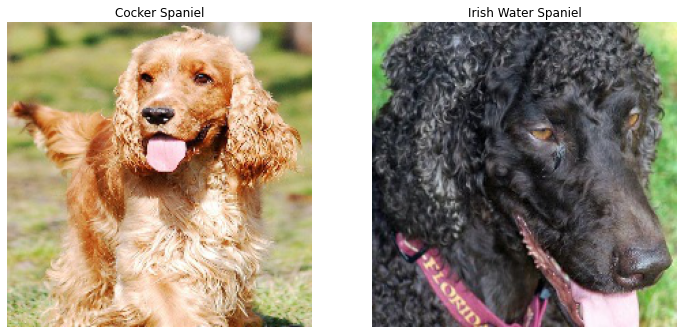

In [313]:
print_pair(mislabeled_imgs[2], 'Cocker Spaniel', 'Irish Water Spaniel')

I attribute the mixed up between these two breeds to the fact that the Stanford dataset combined images of the English and the American Cocker Spaniels into one group and they actually look quite different. So I believe the model simply did not correctly learn how to identify this class. The Irish Water Spaniel did have pretty good recall score and a precision score of .76, so I believe the model had learn to recognize this breed. 

##### Let's explore the Eskimo Dog which was most confused for a Samoyed'

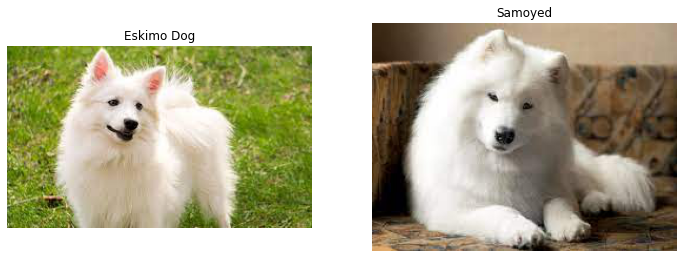

In [314]:
print_pair(mislabeled_imgs[3], 'Eskimo Dog', 'Samoyed')

These two white fluffy breeds share a strikling similarity, so initially, I believed that this mistake happened because of their similar looks. However, I was very skeptical that the Eskimo dog had 0.0 in precision and 0.0 in recal scores, and upon further investigation, I see that the Stanford data completely misclassified the Eskimo Dog, and added pictures from another breed. Because at this point of my project, it is too late to retrain my model and do a completely new analysis, I will simply say that we cannot count the Eskimo dog as a breed that the model learned and then misclassified since the data was corrupted. 

#### Review of the Lakeland Terrier which was most misclassified as an Airedale

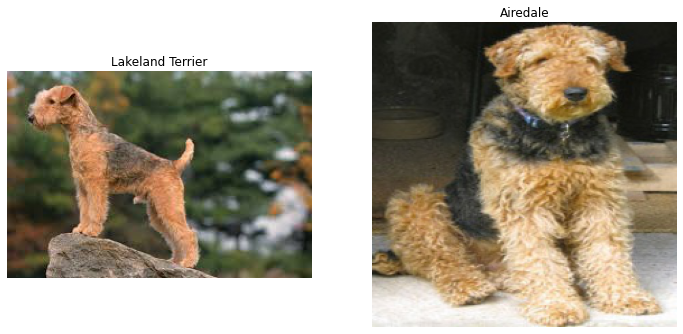

In [318]:
print_pair(mislabeled_imgs[4], 'Lakeland Terrier', 'Airedale')

### Review of breeds with low precision score

In [75]:
def precision_mislabeling(df, breed_list, index_dict):
    '''
    Function that returns dictionary where the keys are breeds with low recall scores
    and values are the breeds that they are mislabeled as the most.  
    
    '''
    mispred_dict = {}
    for breed in breed_list:
        df_subset = df[df['y_pred']==class_indeces[breed]]
        mislabel_ind = df_subset[df_subset['y_true']!=class_indeces[breed]]
        most_mislabed = mislabel_ind['y_true'].mode()[0]
        most_mislabed_breed = ind_to_label[most_mislabed]
        mispred_dict[breed] = most_mislabed_breed
    
    return mispred_dict

In [143]:
low_precision_dict = precision_mislabeling(true_pred, low_precision, ind_to_label)
low_precision_dict

{'Eskimo Dog': 'Siberian Husky',
 'Giant Schnauzer': 'Bouvier Des Flandres',
 'Kelpie': 'Malinois',
 'Miniature Poodle': 'Standard Poodle',
 'Scottish Deerhound': 'Irish Wolfhound',
 'Silky Terrier': 'Yorkshire Terrier',
 'Tibetan Terrier': 'Lhasa'}

### Confusion Matrix for single-breed predictions
Although I have summarized breeds where the model was many over 50% mistakes in the predictions (recall and precision scores), below, you can further explore the numbers via a confusion matrix. 

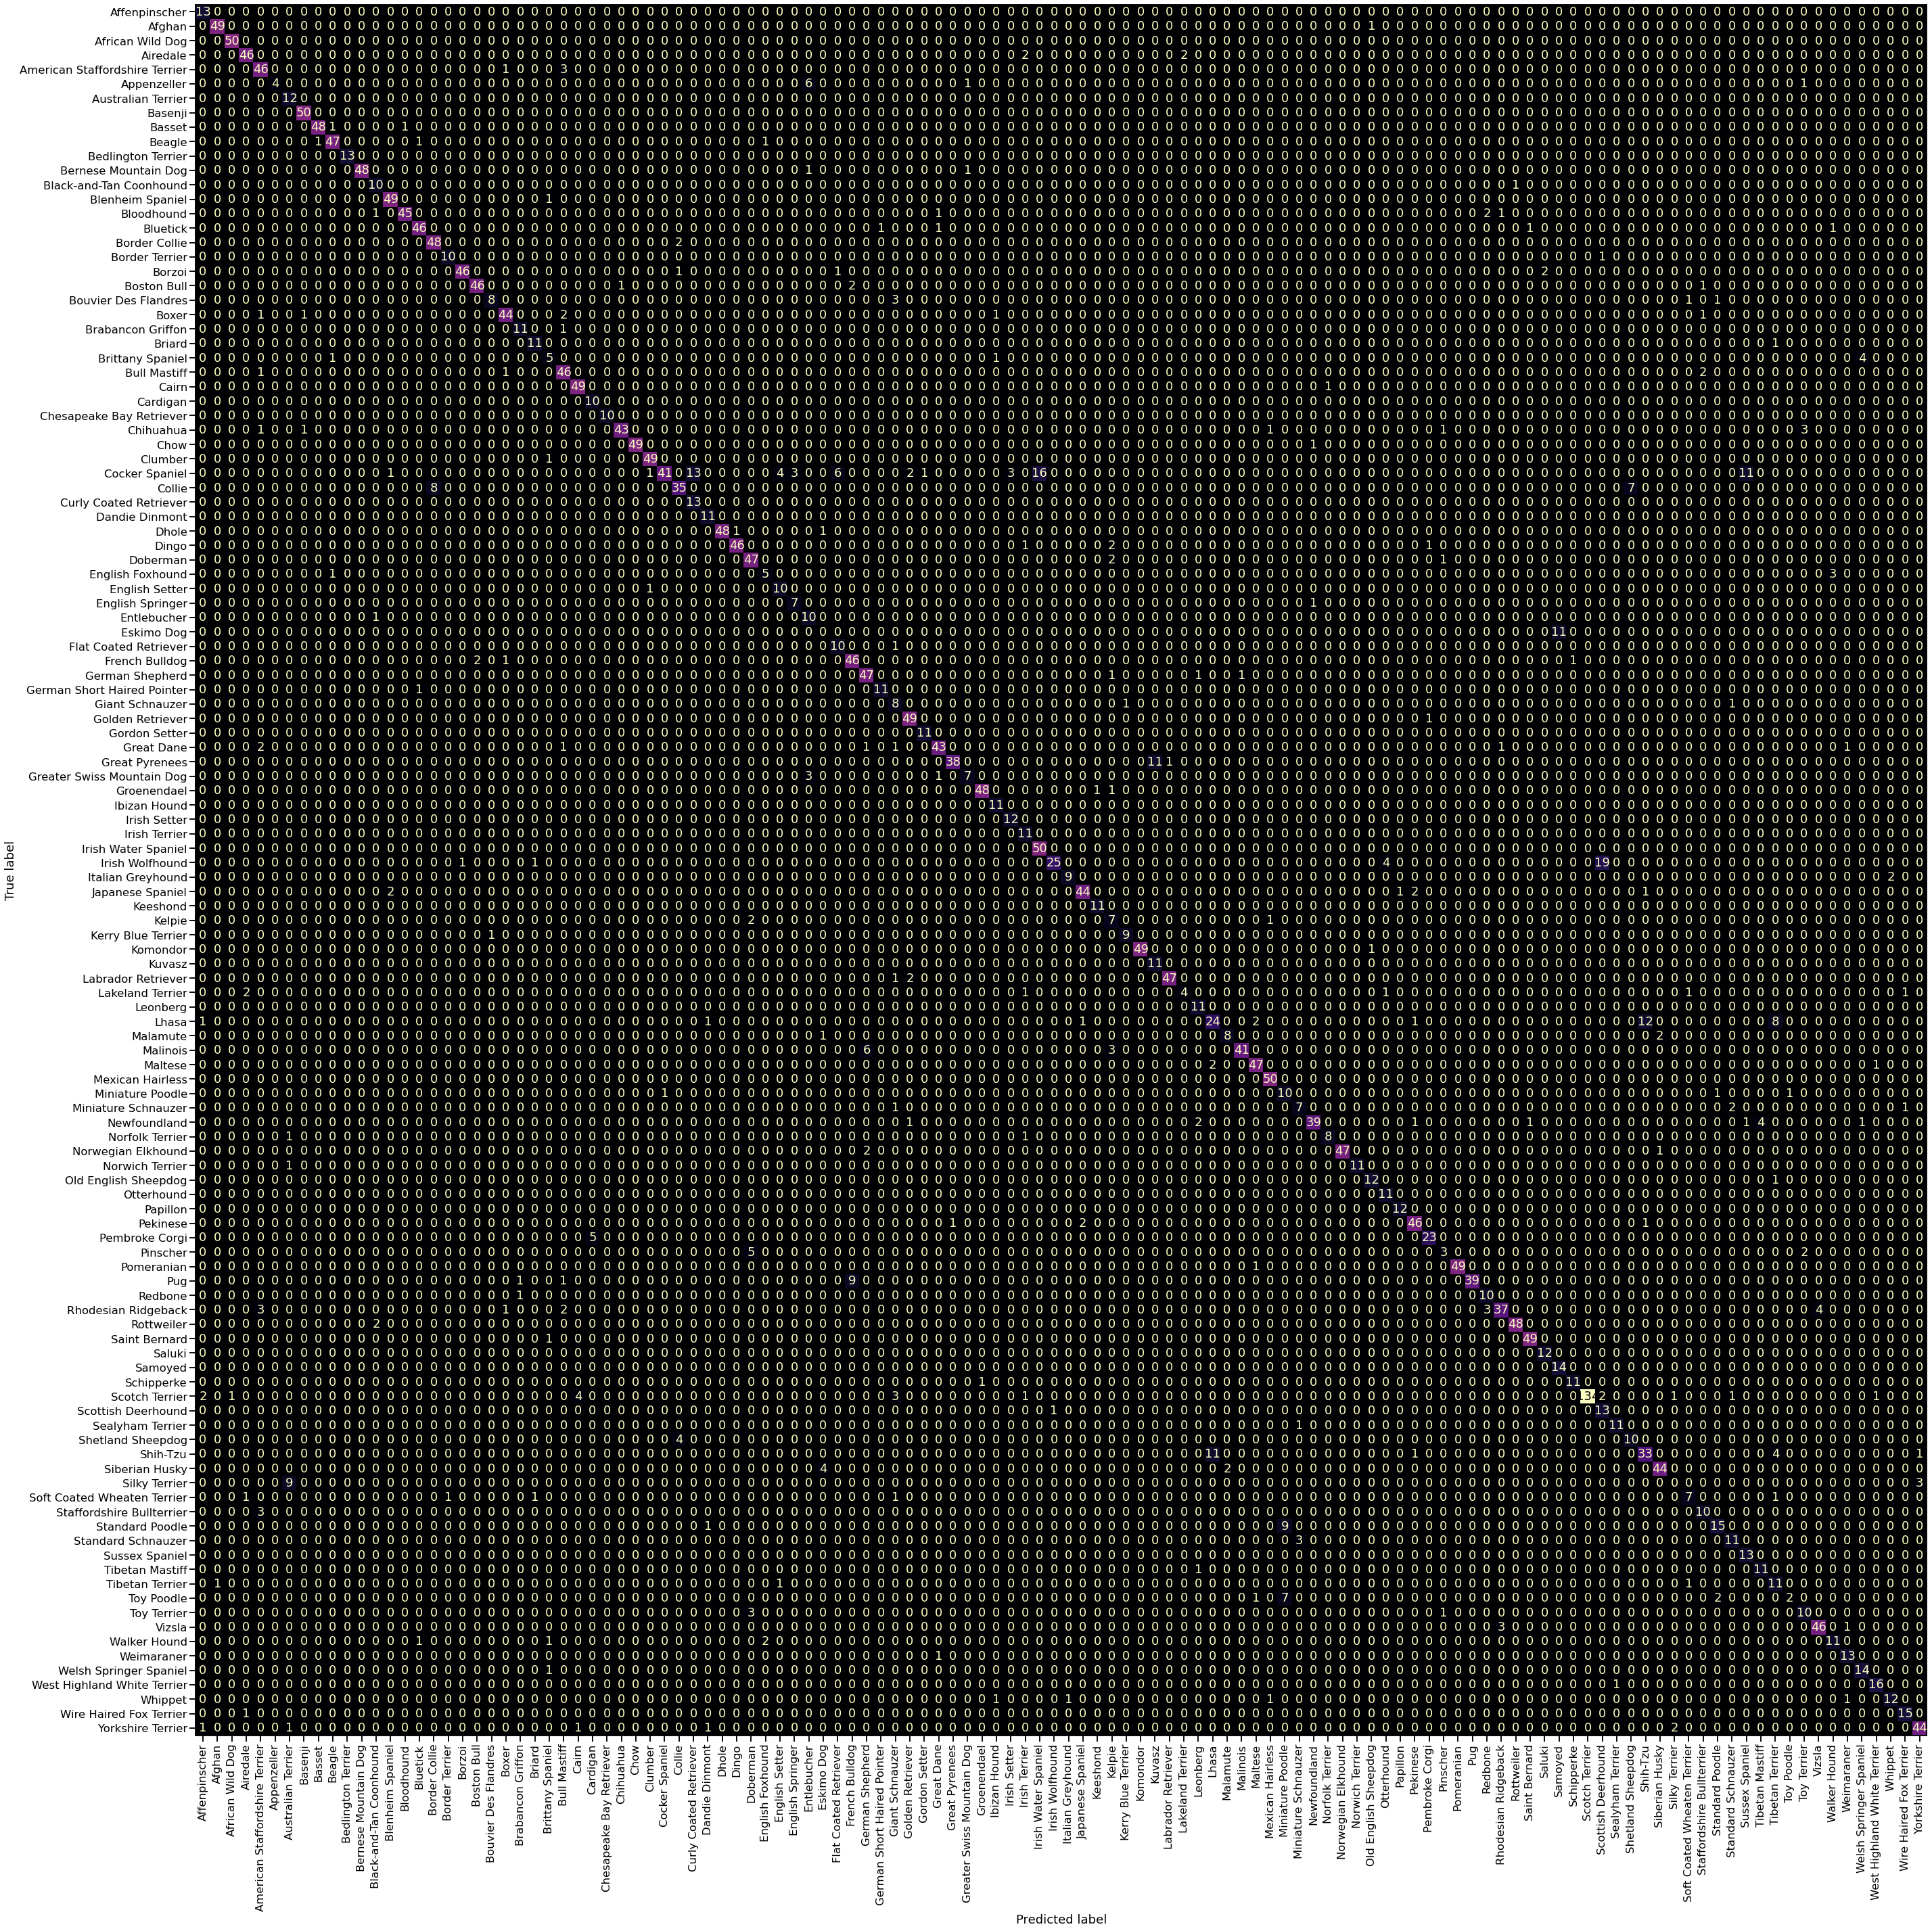

In [61]:
cm = confusion_matrix(y_true, single_breed_preds)
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='magma', colorbar=False)
plt.tight_layout()
plt.show()

## Time for fun: Let's look at how well the model predicts mixed breeds 

In [78]:
mixed_breeds_path = './mix_images/'

In [79]:
mixed_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

mixed_generator = mixed_datagen.flow_from_directory(
    mixed_breeds_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle=False
)

Found 124 images belonging to 12 classes.


In [82]:
mixed_preds = model.predict(mixed_generator)

In [100]:
mixed_preds_sort = np.argsort(mixed_preds, axis=1)

In [264]:
file_path = mixed_generator.filenames

In [265]:
# # list_breeds contains the actual breeds
# list_breeds = []
# for i in file_path:
#     i = i[:i.find('/')]
#     list_breeds.append(i.split('_'))

In [266]:
#predicted preds will have filepath as key and value as the top 10 predicted breeds
predicted_breeds = {}
i = 0
for arr in mixed_preds_sort:
    temp_list = [ind_to_label[index] for index in arr[-10:]]
    predicted_breeds[file_path[i]] = temp_list
    i +=1

In [267]:
pred_breeds = pd.DataFrame(data=predicted_breeds.items(), columns=['file_path', 'predicted_breeds'])
pred_breeds.head()

,file_path,predicted_breeds
0,Bernese Mountain Dog_Standard Poodle/download-...,"[Giant Schnauzer, Collie, Tibetan Mastiff, Ent..."
1,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Otterhound, Border Collie, Afghan, Ol..."
2,Bernese Mountain Dog_Standard Poodle/download-...,"[Otterhound, Shih-Tzu, Collie, Tibetan Mastiff..."
3,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Gordon Setter, Tibetan Terrier, Tibet..."
4,Bernese Mountain Dog_Standard Poodle/download-...,"[Blenheim Spaniel, Border Collie, English Spri..."


In [268]:
def make_title(breeds):
    return [breed.title() for breed in breeds]

In [269]:
def get_breeds(row):
    breed_list = []
    breeds = row['file_path']
    breeds = breeds[:breeds.find('/')]
    breed_list.append(breeds.split('_'))
    outcome = make_title(breed_list[0])
    return outcome

In [270]:
pred_breeds['true_breeds'] = pred_breeds.apply(get_breeds, axis=1)

In [271]:
pred_breeds.tail()

,file_path,predicted_breeds,true_breeds
119,pomeranian_siberian husky/images-3.jpg,"[Collie, Miniature Schnauzer, Kelpie, Cardigan...","[Pomeranian, Siberian Husky]"
120,pomeranian_siberian husky/images-4.jpg,"[Border Collie, Collie, Pembroke Corgi, German...","[Pomeranian, Siberian Husky]"
121,pomeranian_siberian husky/images-5.jpg,"[Collie, Toy Terrier, Dhole, Pembroke Corgi, C...","[Pomeranian, Siberian Husky]"
122,pomeranian_siberian husky/images-6.jpg,"[Border Collie, Tibetan Mastiff, Chihuahua, Bo...","[Pomeranian, Siberian Husky]"
123,pomeranian_siberian husky/images.jpg,"[Papillon, Pomeranian, Pembroke Corgi, Samoyed...","[Pomeranian, Siberian Husky]"


In [272]:
matches = []
for ix in pred_breeds.index:
    predicted_breeds = pred_breeds.loc[ix, 'predicted_breeds']
    actual_breeds = pred_breeds.loc[ix, 'true_breeds']
    matches.append(any([breed in actual_breeds for breed in predicted_breeds]))

pred_breeds['any_matches'] = matches

In [273]:
pred_breeds.head()

,file_path,predicted_breeds,true_breeds,any_matches
0,Bernese Mountain Dog_Standard Poodle/download-...,"[Giant Schnauzer, Collie, Tibetan Mastiff, Ent...","[Bernese Mountain Dog, Standard Poodle]",True
1,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Otterhound, Border Collie, Afghan, Ol...","[Bernese Mountain Dog, Standard Poodle]",False
2,Bernese Mountain Dog_Standard Poodle/download-...,"[Otterhound, Shih-Tzu, Collie, Tibetan Mastiff...","[Bernese Mountain Dog, Standard Poodle]",True
3,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Gordon Setter, Tibetan Terrier, Tibet...","[Bernese Mountain Dog, Standard Poodle]",True
4,Bernese Mountain Dog_Standard Poodle/download-...,"[Blenheim Spaniel, Border Collie, English Spri...","[Bernese Mountain Dog, Standard Poodle]",True


In [274]:
pred_breeds.loc[3, 'predicted_breeds']

['Collie',
 'Gordon Setter',
 'Tibetan Terrier',
 'Tibetan Mastiff',
 'Border Collie',
 'Saint Bernard',
 'Entlebucher',
 'Greater Swiss Mountain Dog',
 'Appenzeller',
 'Bernese Mountain Dog']

In [275]:
pred_breeds.loc[3, 'true_breeds']

['Bernese Mountain Dog', 'Standard Poodle']

In [276]:
pred_breeds['any_matches'].sum()

109

In [277]:
any_accuracy = pred_breeds['any_matches'].sum()/124
any_accuracy

0.8790322580645161

In [278]:
all_matches = []
for ix in pred_breeds.index:
    predicted_breeds = pred_breeds.loc[ix, 'predicted_breeds']
    actual_breeds = pred_breeds.loc[ix, 'true_breeds']
    all_matches.append(all([breed in predicted_breeds for breed in actual_breeds]))

pred_breeds['all_matches'] = all_matches

In [279]:
pred_breeds.head()

,file_path,predicted_breeds,true_breeds,any_matches,all_matches
0,Bernese Mountain Dog_Standard Poodle/download-...,"[Giant Schnauzer, Collie, Tibetan Mastiff, Ent...","[Bernese Mountain Dog, Standard Poodle]",True,False
1,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Otterhound, Border Collie, Afghan, Ol...","[Bernese Mountain Dog, Standard Poodle]",False,False
2,Bernese Mountain Dog_Standard Poodle/download-...,"[Otterhound, Shih-Tzu, Collie, Tibetan Mastiff...","[Bernese Mountain Dog, Standard Poodle]",True,True
3,Bernese Mountain Dog_Standard Poodle/download-...,"[Collie, Gordon Setter, Tibetan Terrier, Tibet...","[Bernese Mountain Dog, Standard Poodle]",True,False
4,Bernese Mountain Dog_Standard Poodle/download-...,"[Blenheim Spaniel, Border Collie, English Spri...","[Bernese Mountain Dog, Standard Poodle]",True,False


In [280]:
pred_breeds['all_matches'].sum()

38

In [261]:
38/124

0.3064516129032258